## Part 2. Feature Selections

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [52]:
## Train-Test data loading
X_train_di = pd.read_csv('X_train_di.csv')
y_train_di = pd.read_csv('y_train_di.csv')
X_test_di = pd.read_csv('X_test_di.csv')
y_test_di = pd.read_csv('y_test_di.csv')
X_train_dif = X_train_di.drop(['group','Unnamed: 0'],axis=1)
X_test_dif = X_test_di.drop(['group','Unnamed: 0'],axis=1)
X_train_dif.head()

,ATP2A1,SLMAP,MEOX2,HOXD3,PANX1,COX8C;KIAA1409,TTC8,Unnamed: 8,TMEM186;PMM2,ANG;RNASE4,...,DAB2IP_1.6,MYCL1_1,KIAA1409;COX8C,ALDH1A3_1.4,ZFP2_1,C11orf24_1,LEPRE1;C1orf50_1.1,GNAS_1.15,RPN1_1,CYB5A_1
0,0.484792,0.239443,0.061837,0.746380,0.041805,0.989804,0.009257,0.630660,0.930137,0.013912,...,0.168725,0.068521,0.972304,0.357425,0.053924,0.024070,0.071891,0.446504,0.010725,0.020359
1,0.548962,0.409014,0.083189,0.751299,0.029187,0.987438,0.012209,0.569969,0.962369,0.015910,...,0.008467,0.025626,0.978987,0.226846,0.021509,0.022556,0.030302,0.201299,0.013245,0.015504
2,0.422701,0.266640,0.046295,0.760732,0.101654,0.990618,0.008969,0.680504,0.943172,0.014931,...,0.007919,0.057673,0.975284,0.318020,0.021148,0.041091,0.045530,0.335190,0.010165,0.040243
3,0.353413,0.145165,0.119947,0.739786,0.044587,0.989208,0.008920,0.619004,0.932849,0.011187,...,0.007669,0.043727,0.980897,0.224292,0.020337,0.024611,0.063894,0.342798,0.010417,0.044794
4,0.375010,0.217041,0.105414,0.770175,0.055885,0.987427,0.010217,0.566641,0.949736,0.012302,...,0.018518,0.081742,0.974721,0.256337,0.038357,0.046272,0.041626,0.422996,0.012968,0.017101


### 2.1 Kruskal-Wallis Method

In [36]:
from scipy import stats
## Split Early and Late Stage Samples; Only use the train test sample!
tumor_G1 = X_tumor[X_tumor.group == 1].drop(['group'],axis=1)
tumor_G2 = X_tumor[X_tumor.group == 2].drop(['group'],axis=1)
Gene = tumor_G1.columns.tolist() # Have a list of genes

## For multiple pair-comparison, type I error keep accumulating! So we need higher threshold
## Setting Different threshold for p < alpha(type I error): alpha = 5e-4, 5e-5, 1e-5
alpha = [5e-4, 5e-5, 1e-5, 5e-2]
gene_kw = [[],[],[],[]]
for n in range(len(alpha)):   
    for z in range(len(Gene)):
        G1 = tumor_G1.iloc[:,z]
        G2 = tumor_G2.iloc[:,z]
        p = stats.kruskal(G1, G2)[1]
        
        if p < alpha[n]:
            gene_kw[n].append(Gene[z])
    print(len(gene_kw[n]))   

95
20
6
3659


### 2.2 Feature Selection: LDA (Linear Discriminant Analysis)

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
     # https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
# Linear Discriminant Analysis (LDA):
  # A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule
  # The model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix.  

lda = LDA(solver="svd", store_covariance=True) #Singular value decomposition (default). Does not compute the covariance matrix, therefore this solver is recommended for data with a large number of features.
Tumor = X_tumor.drop(['group'], axis=1)
X = Tumor[gene_kw[3]] #  whole data is too large for LDA!
y = y_tumor.values.ravel()

lda.fit(X,y)
coef = lda.coef_

## 1. Sort the coefficients, then select top 95, 20, and 6 features
## 2. Save index, then select corresponding genes!
g_coef = coef[0]
number = [95,20,6]
gene_lda = [[],[],[]]

for n in range(len(number)):
    index = np.argsort(g_coef)[:number[n]] # numpy.argsort(list): sort the list and output the original index
    gene_lda[n] = [Gene[i] for i in index]
    print(len(gene_lda[n]))

95
20
6


/home/czl/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


## Part 3. Classifier

### 3.0 ROC Curve Module

In [39]:
def ROC(clf, X_train,y_train, X_test, y_test):
    y_test_true = y_test
    y_test_probas = clf.predict_proba(X_test)[:,1]

    y_train_true = y_train
    y_train_probas = clf.predict_proba(X_train)[:,1]

    fpr_test, tpr_test, threshold_test = metrics.roc_curve(y_test_true, y_test_probas,pos_label=2) # label 2 as postiive label
    roc_auc_test = metrics.auc(fpr_test, tpr_test)

    #print(roc_auc_test)

    fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train_true, y_train_probas,pos_label=2)
    roc_auc_train = metrics.auc(fpr_train, tpr_train)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr_test, tpr_test, 'b', label = 'test AUC = %0.2f' % roc_auc_test)
    plt.plot(fpr_train, tpr_train, 'g', label = 'train AUC = %0.2f' % roc_auc_train)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### 3.1 Random Forest (with Hyperparameters Tuning)

In [40]:
# Define Random Forest Module
import sklearn
from sklearn.model_selection import GridSearchCV # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.ensemble import RandomForestClassifier # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn import metrics
from sklearn.metrics import roc_auc_score

def randomforest(X_train,y_train, X_test, y_test):
    clf = RandomForestClassifier(random_state = 1)
    grid = {'n_estimators': np.power(2, np.arange(0, 10)), 'max_depth': np.arange(1, 4)}#, 'max_depth': np.arange(1, 10)} # n_estimators: number of trees
    gs = GridSearchCV(clf, grid, scoring='roc_auc', cv=5) # scoring: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    gs.fit(X_train,y_train)
    
    ## After CV, input optimized hyperparameters to test model below!!
    ## Part 2. Test model on "Test set"
    clf = RandomForestClassifier(n_estimators = gs.best_params_['n_estimators'], max_depth = gs.best_params_['max_depth'])
    clf.fit(X_train,y_train)
    print(clf.predict(X_test))
    print('Accuracy: ',sklearn.metrics.accuracy_score(y_test, clf.predict(X_test), normalize=True, sample_weight=None))
    
    ## Part 3. ROC curve
    ROC(clf, X_train,y_train, X_test, y_test)

[1 1 1 2 2 2 1 1 1 1 2 1 2 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 1 1 1 2 1
 1 1 1 1 2 1 2 2 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 2 2]
Accuracy:  0.6666666666666666


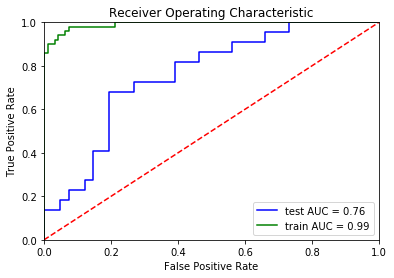

[1 1 1 2 2 2 1 1 1 1 2 1 2 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 1 1 1 2 1
 1 1 1 1 2 1 2 2 1 2 1 1 1 2 1 2 1 1 2 1 1 2 1 2 2 2]
Accuracy:  0.6984126984126984


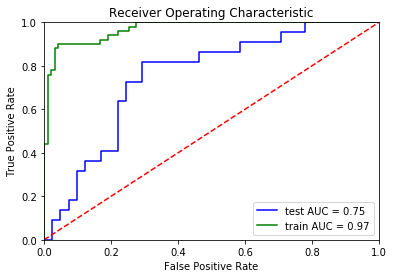

[1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1
 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2]
Accuracy:  0.6825396825396826


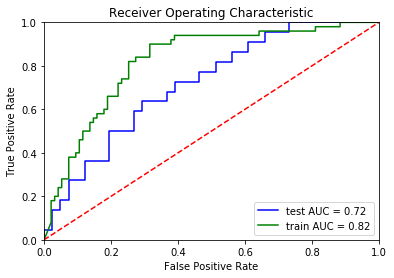

In [42]:
## Put 82, 19, and 5 features selected by K-W method into random forest classifier
for n in range(len(gene_kw)-1):
    X_train = X_train_dif[gene_kw[n]] 
    y_train = y_train_di.values.ravel()
    X_test = X_test_dif[gene_kw[n]]
    y_test = y_test_di.values.ravel()
    randomforest(X_train,y_train, X_test, y_test)

## Test: Gradient Boosting

In [43]:
# https://scikit-learn.org/stable/modules/ensemble.html#classification
from sklearn.ensemble import GradientBoostingClassifier
def gradientboost(X_train,y_train, X_test, y_test):
    clf = GradientBoostingClassifier(learning_rate=1.0, random_state=0)
    grid = {'n_estimators': np.power(2, np.arange(0, 10)), 'max_depth': np.arange(1, 4)}#, 'max_depth': np.arange(1, 10)} # n_estimators: number of trees
    gs = GridSearchCV(clf, grid, scoring='roc_auc', cv=5) # scoring: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    gs.fit(X_train,y_train)
    
    ## After CV, input optimized hyperparameters to test model below!!
    ## Part 2. Test model on "Test set"
    clf = GradientBoostingClassifier(learning_rate=1.0, random_state=0,
        n_estimators = gs.best_params_['n_estimators'], max_depth = gs.best_params_['max_depth'])
    clf.fit(X_train,y_train)
    print(clf.predict(X_test))
    print('Accuracy: ',sklearn.metrics.accuracy_score(y_test, clf.predict(X_test), normalize=True, sample_weight=None))
    
    ## Part 3. ROC curve
    ROC(clf, X_train,y_train, X_test, y_test)

[2 1 1 2 2 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 2 1 1 1 1 2 1
 1 1 1 1 2 2 2 1 1 2 2 1 1 1 1 2 1 1 2 1 1 2 1 2 2 2]
Accuracy:  0.746031746031746


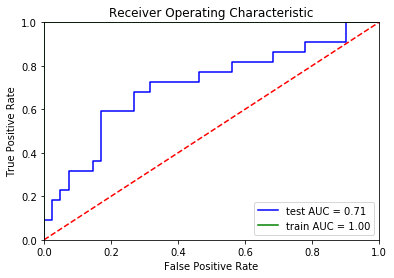

[1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 2 1 2 1 2 1 2 1 1 1 1 1 2 1 2 2 1 1 1 2 1
 1 1 1 1 2 2 2 1 1 2 1 2 1 2 2 2 1 1 2 1 1 2 2 2 2 2]
Accuracy:  0.7142857142857143


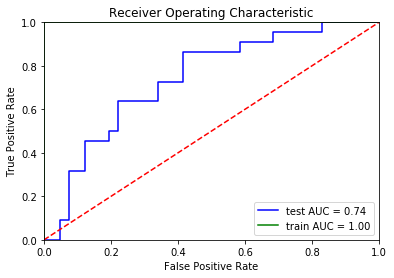

[2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 1
 1 2 1 1 2 2 1 1 1 2 2 1 1 2 1 2 1 1 1 2 1 2 1 1 2 1]
Accuracy:  0.6349206349206349


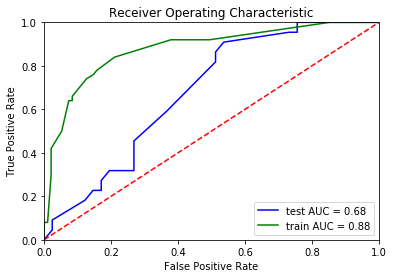

In [44]:
## Put 95, 20, and 6 features selected by K-W method into random forest classifier
for n in range(len(gene_kw)-1):
    X_train = X_train_dif[gene_kw[n]] 
    y_train = y_train_di.values.ravel()
    X_test = X_test_dif[gene_kw[n]]
    y_test = y_test_di.values.ravel()
    gradientboost(X_train,y_train, X_test, y_test)

### 3.2 Logistic Regression (with Hyperparameters Tuning)

In [45]:
# Define Random Forest Module
import sklearn
from sklearn.model_selection import GridSearchCV # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.ensemble import RandomForestClassifier # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn import metrics
from sklearn.metrics import roc_auc_score

def randomforest(X_train,y_train, X_test, y_test):
    clf = RandomForestClassifier(random_state = 1)
    grid = {'n_estimators': np.power(2, np.arange(0, 10)), 'max_depth': np.arange(1, 4)}#, 'max_depth': np.arange(1, 10)} # n_estimators: number of trees
    gs = GridSearchCV(clf, grid, scoring='roc_auc', cv=5) # scoring: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    gs.fit(X_train,y_train)
    
    ## After CV, input optimized hyperparameters to test model below!!
    ## Part 2. Test model on "Test set"
    clf = RandomForestClassifier(n_estimators = gs.best_params_['n_estimators'], max_depth = gs.best_params_['max_depth'])
    clf.fit(X_train,y_train)
    print(clf.predict(X_test))
    print('Accuracy: ',sklearn.metrics.accuracy_score(y_test, clf.predict(X_test), normalize=True, sample_weight=None))
    
    ## Part 3. ROC curve
    ROC(clf, X_train,y_train, X_test, y_test)

In [46]:
# Define Logistic Regression Module
  # https://chrisalbon.com/machine_learning/model_selection/hyperparameter_tuning_using_grid_search/
from sklearn.linear_model import LogisticRegression # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
def logistic(X_train,y_train, X_test, y_test):
    logreg = LogisticRegression(solver='liblinear',max_iter = 1000) # this solver works for l1 and l2 penalty
    grid = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]} # np.logspace(-3,3,7): from 1e-3 to 1e3, take 7 points
    logreg_cv = GridSearchCV(logreg, grid, scoring='roc_auc' , cv = 5) # cv: cross-validation generator
    best_model = logreg_cv.fit(X_train,y_train)
    
    ## Part 2. Use the best_model for prediction
    print(sklearn.metrics.accuracy_score(y_test, best_model.predict(X_test), normalize=True, sample_weight=None))
    
    ## Part 3. ROC curve
    ROC(best_model, X_train,y_train, X_test, y_test)


0.6507936507936508


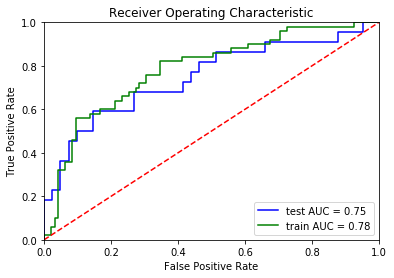

0.7301587301587301


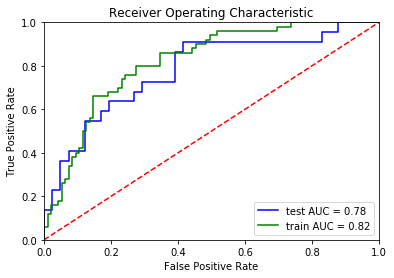

0.6507936507936508


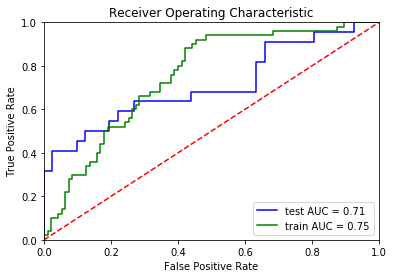

In [47]:
## Put 95, 20, and 6 features selected by K-W method into random forest classifier
for n in range(len(gene_kw)-1):
    X_train = X_train_dif[gene_kw[n]] 
    y_train = y_train_di.values.ravel()
    X_test = X_test_dif[gene_kw[n]]
    y_test = y_test_di.values.ravel()
    logistic(X_train,y_train, X_test, y_test)

## Results

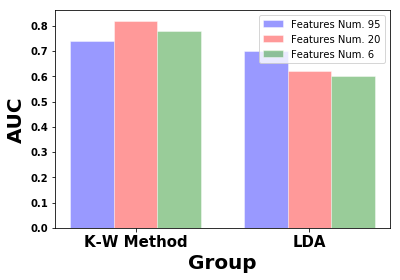

In [53]:
# set width of bar
barWidth = 0.25
 
# Set opacity of bar
opacity = 0.4
    
# set height of bar
bars1 = [.74, .70]
bars2 = [.82, .62]
bars3 = [.78, .60]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, alpha=opacity, color='b', width=barWidth, edgecolor='white', label='Features Num. 95')
plt.bar(r2, bars2, alpha=opacity, color='r', width=barWidth, edgecolor='white', label='Features Num. 20')
plt.bar(r3, bars3, alpha=opacity, color='g', width=barWidth, edgecolor='white', label='Features Num. 6')

 
# Add xticks on the middle of the group bars
plt.xlabel('Group', size=20, fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['K-W Method', 'LDA'], size=15, fontweight='bold')
plt.ylabel('AUC',size=20, fontweight='bold')
plt.yticks(size=10, fontweight='bold')

# Create legend & Show graphic
plt.legend()
plt.show()